In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
    allow_growth=True
    ))

In [2]:
import pandas as pd
import os
target_path = '../data/LOG_G/stable/'
contents = os.listdir(target_path)
data = pd.DataFrame()
num = 0
for c in range(len(contents)):
    print(target_path+contents[c])
    n_data = pd.read_csv(target_path+contents[c],header=None)
    data = pd.concat([data,n_data])

print(len(data))
d = data
#print(ball)
#print(joy)

../data/LOG_G/stable/log201807311344.csv
../data/LOG_G/stable/log201807292107.csv
../data/LOG_G/stable/log201807292213.csv
../data/LOG_G/stable/log201807311352.csv
../data/LOG_G/stable/log201807311349.csv
../data/LOG_G/stable/log201807292116.csv
../data/LOG_G/stable/log201807311336.csv
../data/LOG_G/stable/log201807292215.csv
../data/LOG_G/stable/log201807292207.csv
../data/LOG_G/stable/log201807292110.csv
../data/LOG_G/stable/log201807311347.csv
32853


In [3]:
d.columns = ['l_bx','l_by','l_pole0x','l_pole0y','l_pole1x','l_pole1y','g_bx','g_by','g_pole0x','g_pole0y','g_pole1x','g_pole1y','g_px','g_py','g_pth','ljx','ljy','rjx','rjy']
#d = d[d.bx!=-1]

In [4]:
'''
from sklearn.cross_validation import train_test_split
t1 = []
t2 = []
def f1(x,y):
    return y * np.sin(x) + np.square(x)
def f2(x,y):
    return x * np.cos(y) + np.square(y)
for a in range(1000):
    r = np.array([np.random.rand(), np.random.rand()])
    t1.append(r)
    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))
IN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)

IN_train = np.array(IN_train)
IN_test = np.array(IN_test)
TAR_train = np.array(TAR_train)
TAR_test = np.array(TAR_test)
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])
print(f1(1,1))
print(f2(1,1))
'''

'\nfrom sklearn.cross_validation import train_test_split\nt1 = []\nt2 = []\ndef f1(x,y):\n    return y * np.sin(x) + np.square(x)\ndef f2(x,y):\n    return x * np.cos(y) + np.square(y)\nfor a in range(1000):\n    r = np.array([np.random.rand(), np.random.rand()])\n    t1.append(r)\n    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))\nIN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)\n\nIN_train = np.array(IN_train)\nIN_test = np.array(IN_test)\nTAR_train = np.array(TAR_train)\nTAR_test = np.array(TAR_test)\nprint(IN_train[0])\nprint(IN_test[0])\nprint(TAR_train[0])\nprint(TAR_test[0])\nprint(f1(1,1))\nprint(f2(1,1))\n'

In [5]:
from sklearn.cross_validation import train_test_split
l_ball = np.array(d.iloc[:,0:2])
l_pole0 = np.array(d.iloc[:,2:4])
l_pole1 = np.array(d.iloc[:,4:6])
input_d = np.array(d.iloc[:,0:6])
g_ball = np.array(d.iloc[:,6:8])
g_pole0 = np.array(d.iloc[:,8:10])
g_pole1 = np.array(d.iloc[:,10:12])
g_pos = np.array(d.iloc[:,12:14])
output_d = np.array(d.iloc[:,14:18])
ljoy = np.array(d.iloc[:,14:16])
rjoy = np.array(d.iloc[:,16:18])

input_d = np.array(d.iloc[:,0:6])
output_d = np.array(d.iloc[:,15:18])
print(input_d.shape)
print(output_d.shape)

IN_train, IN_test, TAR_train, TAR_test = train_test_split(input_d,output_d,test_size=0.2,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
#IN_train = IN_train/100.0
#IN_test = IN_test/100.0
for t in range(10):
    print(IN_train[t])
'''
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])
'''

(32853, 6)
(32853, 3)
[ 0.26507283 -0.12912751  1.93868955  2.07983174  2.28975789 -0.49635751]
[ 0.7522718   0.32540024  1.74107202  2.07986238  2.89844302 -0.24833272]
[ 0.40731088 -0.01143569  1.49269182  0.32712971  1.22747513 -2.25930801]
[2.82947013 1.27166372 1.00351973 3.19039456 3.31746766 2.00479555]
[ 3.10863438 -0.73276001  6.68595478  1.98437951  7.59210989 -0.45260283]
[2.67322077 1.01560967 1.01623561 3.08201294 3.22152338 1.7048035 ]
[ 0.44459806  0.38500604  1.49200801  1.93614835  2.3476051  -0.51904077]
[ 0.52533711 -0.0316782   0.88645154  0.96624206  3.01853728 -0.52178025]
[ 0.54904566  0.07638845  1.39258296  1.52994657  1.75798521 -1.04424868]
[2.39541926 0.03300046 3.05722124 2.59769167 3.27572722 0.00688965]


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'\nprint(IN_train[0])\nprint(IN_test[0])\nprint(TAR_train[0])\nprint(TAR_test[0])\n'

In [6]:
#　初期化
sess = tf.Session(config=config)
test_sess = tf.Session(config=config)

IN_size = 6
TAR_size = 3
INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

In [7]:
#hidden_size = [100]
hidden_size = [10,5,5]
batch_size = 100
iter_size = 100000

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]
print(final_output)

Tensor("Relu:0", shape=(?, 10), dtype=float32)
Tensor("Relu_1:0", shape=(?, 5), dtype=float32)
Tensor("Relu_2:0", shape=(?, 5), dtype=float32)
Tensor("Add_3:0", shape=(?, 3), dtype=float32)


In [8]:
#　学習
loss = tf.losses.mean_squared_error(TARGET,final_output)
test_loss = tf.losses.mean_squared_error(TARGET,final_output)
opt = tf.train.AdamOptimizer(0.001)
#opt = tf.train.GradientDescentOptimizer(0.01)
train_step = opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)
test_sess.run(init)
loss_vec=[]
test_loss_vec=[]
for i in range(iter_size):
    train_rand_index = np.random.choice(len(IN_train), size=batch_size,replace=False)
    train_rand_in = IN_train[train_rand_index]
    train_rand_tar = TAR_train[train_rand_index]
    sess.run(train_step, feed_dict={INPUT:train_rand_in, TARGET: train_rand_tar})
    loss_vec.append(sess.run(loss, feed_dict={INPUT:train_rand_in, TARGET: train_rand_tar}))
    
    test_rand_index = np.random.choice(len(IN_test), size=batch_size,replace=False)
    test_rand_in = IN_test[test_rand_index]
    test_rand_tar = TAR_test[test_rand_index]
    test_sess.run(train_step, feed_dict={INPUT:test_rand_in, TARGET: test_rand_tar})
    test_loss_vec.append(test_sess.run(test_loss, feed_dict={INPUT:test_rand_in, TARGET: test_rand_tar}))
    
    if (i+1)%25==0:
#        print(sess.run(INPUT, feed_dict={INPUT:rand_in, TARGET: rand_tar}))
        print('Generation:'+str(i+1)+', Loss = '+str(loss_vec[-1]))

Generation:25, Loss = 14877246000.0
Generation:50, Loss = 15203449000.0
Generation:75, Loss = 14714914000.0
Generation:100, Loss = 11878187000.0
Generation:125, Loss = 11518223000.0
Generation:150, Loss = 14932835000.0
Generation:175, Loss = 14201887000.0
Generation:200, Loss = 9860727000.0
Generation:225, Loss = 11446494000.0
Generation:250, Loss = 10399473000.0
Generation:275, Loss = 11223106000.0
Generation:300, Loss = 10069007000.0
Generation:325, Loss = 12301042000.0
Generation:350, Loss = 9587876000.0
Generation:375, Loss = 11472290000.0
Generation:400, Loss = 7660465700.0
Generation:425, Loss = 10208714000.0
Generation:450, Loss = 7427604000.0
Generation:475, Loss = 7406247000.0
Generation:500, Loss = 7853180400.0
Generation:525, Loss = 6134122500.0
Generation:550, Loss = 7378845700.0
Generation:575, Loss = 6133995500.0
Generation:600, Loss = 6153732000.0
Generation:625, Loss = 7405840000.0
Generation:650, Loss = 7741447700.0
Generation:675, Loss = 6272030700.0
Generation:700, L

Generation:5725, Loss = 15316362.0
Generation:5750, Loss = 81372790.0
Generation:5775, Loss = 153857070.0
Generation:5800, Loss = 101793176.0
Generation:5825, Loss = 54913324.0
Generation:5850, Loss = 63964268.0
Generation:5875, Loss = 23307208.0
Generation:5900, Loss = 94798250.0
Generation:5925, Loss = 87527070.0
Generation:5950, Loss = 33099636.0
Generation:5975, Loss = 29248086.0
Generation:6000, Loss = 72965176.0
Generation:6025, Loss = 5294287.5
Generation:6050, Loss = 29017396.0
Generation:6075, Loss = 23576536.0
Generation:6100, Loss = 31871904.0
Generation:6125, Loss = 32504976.0
Generation:6150, Loss = 17646834.0
Generation:6175, Loss = 38081776.0
Generation:6200, Loss = 29183228.0
Generation:6225, Loss = 31615662.0
Generation:6250, Loss = 11667976.0
Generation:6275, Loss = 29578114.0
Generation:6300, Loss = 2312866.2
Generation:6325, Loss = 12907056.0
Generation:6350, Loss = 51111064.0
Generation:6375, Loss = 48389200.0
Generation:6400, Loss = 18737860.0
Generation:6425, Los

Generation:11675, Loss = 1103341.9
Generation:11700, Loss = 381088.56
Generation:11725, Loss = 10966.648
Generation:11750, Loss = 649313.2
Generation:11775, Loss = 68531.13
Generation:11800, Loss = 474161.06
Generation:11825, Loss = 841.27716
Generation:11850, Loss = 1151420.8
Generation:11875, Loss = 410898.8
Generation:11900, Loss = 110768.25
Generation:11925, Loss = 1635148.9
Generation:11950, Loss = 456847.94
Generation:11975, Loss = 47423.965
Generation:12000, Loss = 1057565.2
Generation:12025, Loss = 1799588.9
Generation:12050, Loss = 16483.684
Generation:12075, Loss = 17095.766
Generation:12100, Loss = 150292.83
Generation:12125, Loss = 743727.56
Generation:12150, Loss = 11216.97
Generation:12175, Loss = 37998.57
Generation:12200, Loss = 274930.12
Generation:12225, Loss = 222512.95
Generation:12250, Loss = 347100.44
Generation:12275, Loss = 94533.125
Generation:12300, Loss = 592262.94
Generation:12325, Loss = 229818.5
Generation:12350, Loss = 486304.84
Generation:12375, Loss = 6

Generation:17675, Loss = 64.42076
Generation:17700, Loss = 64.25731
Generation:17725, Loss = 63.989735
Generation:17750, Loss = 63.758724
Generation:17775, Loss = 63.922077
Generation:17800, Loss = 64.08736
Generation:17825, Loss = 64.075294
Generation:17850, Loss = 63.702538
Generation:17875, Loss = 63.941193
Generation:17900, Loss = 63.851048
Generation:17925, Loss = 63.14569
Generation:17950, Loss = 63.738483
Generation:17975, Loss = 63.484283
Generation:18000, Loss = 63.907005
Generation:18025, Loss = 63.61577
Generation:18050, Loss = 62.8676
Generation:18075, Loss = 62.776443
Generation:18100, Loss = 63.207962
Generation:18125, Loss = 1216.4062
Generation:18150, Loss = 62.970272
Generation:18175, Loss = 63.150112
Generation:18200, Loss = 178196.08
Generation:18225, Loss = 62.653107
Generation:18250, Loss = 62.24905
Generation:18275, Loss = 62.17111
Generation:18300, Loss = 62.595272
Generation:18325, Loss = 62.397305
Generation:18350, Loss = 154923.66
Generation:18375, Loss = 62.1

Generation:23625, Loss = 37.11691
Generation:23650, Loss = 22989.902
Generation:23675, Loss = 36.686314
Generation:23700, Loss = 36.18072
Generation:23725, Loss = 36.446922
Generation:23750, Loss = 35.845646
Generation:23775, Loss = 35.963966
Generation:23800, Loss = 35.890743
Generation:23825, Loss = 35.988235
Generation:23850, Loss = 35.90788
Generation:23875, Loss = 210260.81
Generation:23900, Loss = 3022.4827
Generation:23925, Loss = 35.1721
Generation:23950, Loss = 34.91109
Generation:23975, Loss = 34.63525
Generation:24000, Loss = 34.877583
Generation:24025, Loss = 34.747036
Generation:24050, Loss = 34.615906
Generation:24075, Loss = 34.539356
Generation:24100, Loss = 34.248035
Generation:24125, Loss = 34.292625
Generation:24150, Loss = 34.150356
Generation:24175, Loss = 34.01153
Generation:24200, Loss = 262.86658
Generation:24225, Loss = 33.523167
Generation:24250, Loss = 33.296627
Generation:24275, Loss = 33.495876
Generation:24300, Loss = 33.169346
Generation:24325, Loss = 195

Generation:29525, Loss = 9.434182
Generation:29550, Loss = 9.150656
Generation:29575, Loss = 4826.2485
Generation:29600, Loss = 8.78311
Generation:29625, Loss = 8.951342
Generation:29650, Loss = 8.886429
Generation:29675, Loss = 8.810196
Generation:29700, Loss = 8.729352
Generation:29725, Loss = 8.777105
Generation:29750, Loss = 10.017531
Generation:29775, Loss = 8.57854
Generation:29800, Loss = 8.343469
Generation:29825, Loss = 8.550245
Generation:29850, Loss = 8.24577
Generation:29875, Loss = 8.151198
Generation:29900, Loss = 8.019806
Generation:29925, Loss = 8.192702
Generation:29950, Loss = 7.971127
Generation:29975, Loss = 7.9241595
Generation:30000, Loss = 7.8770313
Generation:30025, Loss = 12.317821
Generation:30050, Loss = 7.6077986
Generation:30075, Loss = 7.6072235
Generation:30100, Loss = 7.4421678
Generation:30125, Loss = 7.4997377
Generation:30150, Loss = 7.5095344
Generation:30175, Loss = 7.289165
Generation:30200, Loss = 7.2057705
Generation:30225, Loss = 7.3605494
Gener

Generation:35425, Loss = 0.31601274
Generation:35450, Loss = 0.32488954
Generation:35475, Loss = 0.2891724
Generation:35500, Loss = 0.28976914
Generation:35525, Loss = 0.38286266
Generation:35550, Loss = 0.30773392
Generation:35575, Loss = 0.2737175
Generation:35600, Loss = 0.28167424
Generation:35625, Loss = 0.31284928
Generation:35650, Loss = 0.24069725
Generation:35675, Loss = 0.31146592
Generation:35700, Loss = 0.28298545
Generation:35725, Loss = 0.2626041
Generation:35750, Loss = 0.2703243
Generation:35775, Loss = 0.2728702
Generation:35800, Loss = 0.23366244
Generation:35825, Loss = 0.23806551
Generation:35850, Loss = 0.22453351
Generation:35875, Loss = 0.23105286
Generation:35900, Loss = 0.22145419
Generation:35925, Loss = 0.21934865
Generation:35950, Loss = 0.20550567
Generation:35975, Loss = 0.16105528
Generation:36000, Loss = 0.20987707
Generation:36025, Loss = 0.18346661
Generation:36050, Loss = 0.22223094
Generation:36075, Loss = 0.18610248
Generation:36100, Loss = 0.168064

Generation:41125, Loss = 0.06669421
Generation:41150, Loss = 0.10245269
Generation:41175, Loss = 0.08002453
Generation:41200, Loss = 0.09209503
Generation:41225, Loss = 0.06922001
Generation:41250, Loss = 0.10001251
Generation:41275, Loss = 0.07217075
Generation:41300, Loss = 0.08916362
Generation:41325, Loss = 0.090242796
Generation:41350, Loss = 0.0713472
Generation:41375, Loss = 0.09222394
Generation:41400, Loss = 0.06471815
Generation:41425, Loss = 0.09054281
Generation:41450, Loss = 0.086238876
Generation:41475, Loss = 0.079535306
Generation:41500, Loss = 0.096668996
Generation:41525, Loss = 0.09299915
Generation:41550, Loss = 0.07217254
Generation:41575, Loss = 0.09835002
Generation:41600, Loss = 0.07700359
Generation:41625, Loss = 0.078207515
Generation:41650, Loss = 0.09823437
Generation:41675, Loss = 0.072202526
Generation:41700, Loss = 0.10015664
Generation:41725, Loss = 0.07437707
Generation:41750, Loss = 0.089188606
Generation:41775, Loss = 0.07159142
Generation:41800, Loss

Generation:46825, Loss = 0.077653624
Generation:46850, Loss = 0.08518881
Generation:46875, Loss = 0.07136632
Generation:46900, Loss = 0.07130456
Generation:46925, Loss = 0.084304385
Generation:46950, Loss = 0.080381624
Generation:46975, Loss = 0.09020715
Generation:47000, Loss = 0.07946066
Generation:47025, Loss = 0.068700954
Generation:47050, Loss = 0.077645384
Generation:47075, Loss = 0.09469252
Generation:47100, Loss = 0.0822041
Generation:47125, Loss = 0.07219965
Generation:47150, Loss = 0.08617205
Generation:47175, Loss = 0.07455796
Generation:47200, Loss = 0.07359533
Generation:47225, Loss = 0.073323704
Generation:47250, Loss = 0.1003095
Generation:47275, Loss = 0.07643646
Generation:47300, Loss = 0.094182126
Generation:47325, Loss = 0.10646584
Generation:47350, Loss = 0.077973165
Generation:47375, Loss = 0.080655746
Generation:47400, Loss = 0.08198679
Generation:47425, Loss = 0.07737356
Generation:47450, Loss = 0.07327141
Generation:47475, Loss = 0.09364004
Generation:47500, Los

Generation:52525, Loss = 0.088129185
Generation:52550, Loss = 0.07342768
Generation:52575, Loss = 0.064714186
Generation:52600, Loss = 0.07438619
Generation:52625, Loss = 0.075134285
Generation:52650, Loss = 0.092015915
Generation:52675, Loss = 0.07401942
Generation:52700, Loss = 0.07634608
Generation:52725, Loss = 0.09047844
Generation:52750, Loss = 0.07272882
Generation:52775, Loss = 0.09479391
Generation:52800, Loss = 0.077556975
Generation:52825, Loss = 0.08167873
Generation:52850, Loss = 0.06999471
Generation:52875, Loss = 0.07439808
Generation:52900, Loss = 0.07269873
Generation:52925, Loss = 0.07154706
Generation:52950, Loss = 0.08160029
Generation:52975, Loss = 0.065637484
Generation:53000, Loss = 0.0726876
Generation:53025, Loss = 0.08200954
Generation:53050, Loss = 0.07844647
Generation:53075, Loss = 0.095615625
Generation:53100, Loss = 0.0840676
Generation:53125, Loss = 0.09182923
Generation:53150, Loss = 0.083522215
Generation:53175, Loss = 0.074735865
Generation:53200, Los

Generation:58225, Loss = 0.07142329
Generation:58250, Loss = 0.07406575
Generation:58275, Loss = 0.089868285
Generation:58300, Loss = 0.057178397
Generation:58325, Loss = 0.093593314
Generation:58350, Loss = 0.08492789
Generation:58375, Loss = 0.082132615
Generation:58400, Loss = 0.089497246
Generation:58425, Loss = 0.08767746
Generation:58450, Loss = 0.10491844
Generation:58475, Loss = 0.07938088
Generation:58500, Loss = 0.0828023
Generation:58525, Loss = 0.08826639
Generation:58550, Loss = 0.082451634
Generation:58575, Loss = 0.06774372
Generation:58600, Loss = 0.06693461
Generation:58625, Loss = 0.083543904
Generation:58650, Loss = 0.06696771
Generation:58675, Loss = 0.069751486
Generation:58700, Loss = 0.07657233
Generation:58725, Loss = 0.08511965
Generation:58750, Loss = 0.072901875
Generation:58775, Loss = 0.0722337
Generation:58800, Loss = 0.07189813
Generation:58825, Loss = 0.07424791
Generation:58850, Loss = 0.085602425
Generation:58875, Loss = 0.082318954
Generation:58900, L

Generation:63925, Loss = 0.060154475
Generation:63950, Loss = 0.06991728
Generation:63975, Loss = 0.09379712
Generation:64000, Loss = 0.09210714
Generation:64025, Loss = 0.078942195
Generation:64050, Loss = 0.07521086
Generation:64075, Loss = 0.08161293
Generation:64100, Loss = 0.08486699
Generation:64125, Loss = 0.06856927
Generation:64150, Loss = 0.100570716
Generation:64175, Loss = 0.076286726
Generation:64200, Loss = 0.0677042
Generation:64225, Loss = 0.071157
Generation:64250, Loss = 0.10037226
Generation:64275, Loss = 0.08545763
Generation:64300, Loss = 0.08668408
Generation:64325, Loss = 0.09527641
Generation:64350, Loss = 0.068951935
Generation:64375, Loss = 0.08141502
Generation:64400, Loss = 0.08047696
Generation:64425, Loss = 0.094941184
Generation:64450, Loss = 0.07650598
Generation:64475, Loss = 0.09023976
Generation:64500, Loss = 0.07880881
Generation:64525, Loss = 0.08747734
Generation:64550, Loss = 0.07682861
Generation:64575, Loss = 0.09234589
Generation:64600, Loss = 

Generation:69625, Loss = 0.07283018
Generation:69650, Loss = 0.068936385
Generation:69675, Loss = 0.08102068
Generation:69700, Loss = 0.07798317
Generation:69725, Loss = 0.08947319
Generation:69750, Loss = 0.09529608
Generation:69775, Loss = 0.065795004
Generation:69800, Loss = 0.088778265
Generation:69825, Loss = 0.09035543
Generation:69850, Loss = 0.10477114
Generation:69875, Loss = 0.065675676
Generation:69900, Loss = 0.1140588
Generation:69925, Loss = 0.09095926
Generation:69950, Loss = 0.08881459
Generation:69975, Loss = 0.070225894
Generation:70000, Loss = 0.068865806
Generation:70025, Loss = 0.07500377
Generation:70050, Loss = 0.07178276
Generation:70075, Loss = 0.09676671
Generation:70100, Loss = 0.08333811
Generation:70125, Loss = 0.08845243
Generation:70150, Loss = 0.06941968
Generation:70175, Loss = 0.08932903
Generation:70200, Loss = 0.075001925
Generation:70225, Loss = 0.06574131
Generation:70250, Loss = 0.099258356
Generation:70275, Loss = 0.05488175
Generation:70300, Los

Generation:75325, Loss = 0.07304949
Generation:75350, Loss = 0.099386625
Generation:75375, Loss = 0.07992556
Generation:75400, Loss = 0.10001584
Generation:75425, Loss = 0.08344502
Generation:75450, Loss = 0.080575846
Generation:75475, Loss = 0.074149355
Generation:75500, Loss = 0.07333399
Generation:75525, Loss = 0.06447157
Generation:75550, Loss = 0.07570003
Generation:75575, Loss = 0.09879036
Generation:75600, Loss = 0.07394961
Generation:75625, Loss = 0.06783079
Generation:75650, Loss = 0.07691655
Generation:75675, Loss = 0.07814747
Generation:75700, Loss = 0.09633487
Generation:75725, Loss = 0.08050097
Generation:75750, Loss = 0.08010292
Generation:75775, Loss = 0.079173416
Generation:75800, Loss = 0.08997109
Generation:75825, Loss = 0.0677728
Generation:75850, Loss = 0.09567649
Generation:75875, Loss = 0.087516785
Generation:75900, Loss = 0.099501915
Generation:75925, Loss = 0.083634526
Generation:75950, Loss = 0.081083626
Generation:75975, Loss = 0.101692006
Generation:76000, Lo

Generation:81025, Loss = 0.08234685
Generation:81050, Loss = 0.08506919
Generation:81075, Loss = 0.09255883
Generation:81100, Loss = 0.088602975
Generation:81125, Loss = 0.080892496
Generation:81150, Loss = 0.07923135
Generation:81175, Loss = 0.077996455
Generation:81200, Loss = 0.079620846
Generation:81225, Loss = 0.08960917
Generation:81250, Loss = 0.09521551
Generation:81275, Loss = 0.08402401
Generation:81300, Loss = 0.07702198
Generation:81325, Loss = 0.091302045
Generation:81350, Loss = 0.056550547
Generation:81375, Loss = 0.09109644
Generation:81400, Loss = 0.07704277
Generation:81425, Loss = 0.10133656
Generation:81450, Loss = 0.08304275
Generation:81475, Loss = 0.0880498
Generation:81500, Loss = 0.08465587
Generation:81525, Loss = 0.0900887
Generation:81550, Loss = 0.08866134
Generation:81575, Loss = 0.07558194
Generation:81600, Loss = 0.069969885
Generation:81625, Loss = 0.089979246
Generation:81650, Loss = 0.10712092
Generation:81675, Loss = 0.0766882
Generation:81700, Loss 

Generation:86725, Loss = 0.073013395
Generation:86750, Loss = 0.07689462
Generation:86775, Loss = 0.07426273
Generation:86800, Loss = 0.09230798
Generation:86825, Loss = 0.095295236
Generation:86850, Loss = 0.08375203
Generation:86875, Loss = 0.06620941
Generation:86900, Loss = 0.07579864
Generation:86925, Loss = 0.07646051
Generation:86950, Loss = 0.07469508
Generation:86975, Loss = 0.08687841
Generation:87000, Loss = 0.07118166
Generation:87025, Loss = 0.0910642
Generation:87050, Loss = 0.062000077
Generation:87075, Loss = 0.06278686
Generation:87100, Loss = 0.09423532
Generation:87125, Loss = 0.08159853
Generation:87150, Loss = 0.075895935
Generation:87175, Loss = 0.08391278
Generation:87200, Loss = 0.08130145
Generation:87225, Loss = 0.076174624
Generation:87250, Loss = 0.08327436
Generation:87275, Loss = 0.08783684
Generation:87300, Loss = 0.062068056
Generation:87325, Loss = 0.09594337
Generation:87350, Loss = 0.08071918
Generation:87375, Loss = 0.086674325
Generation:87400, Loss

Generation:92425, Loss = 0.07764582
Generation:92450, Loss = 0.08148821
Generation:92475, Loss = 0.06973199
Generation:92500, Loss = 0.08593437
Generation:92525, Loss = 0.078212686
Generation:92550, Loss = 0.08051136
Generation:92575, Loss = 0.07834896
Generation:92600, Loss = 0.06866194
Generation:92625, Loss = 0.08377522
Generation:92650, Loss = 0.08368722
Generation:92675, Loss = 0.078303576
Generation:92700, Loss = 0.08467097
Generation:92725, Loss = 0.06375056
Generation:92750, Loss = 0.08391928
Generation:92775, Loss = 0.08650238
Generation:92800, Loss = 0.07159143
Generation:92825, Loss = 0.06697952
Generation:92850, Loss = 0.07294356
Generation:92875, Loss = 0.09206656
Generation:92900, Loss = 0.06771065
Generation:92925, Loss = 0.0817652
Generation:92950, Loss = 0.08648693
Generation:92975, Loss = 0.08438227
Generation:93000, Loss = 0.089765236
Generation:93025, Loss = 0.07822697
Generation:93050, Loss = 0.065287635
Generation:93075, Loss = 0.08432027
Generation:93100, Loss = 

Generation:98125, Loss = 0.0846605
Generation:98150, Loss = 0.08706176
Generation:98175, Loss = 0.101897344
Generation:98200, Loss = 0.08503526
Generation:98225, Loss = 0.08080688
Generation:98250, Loss = 0.096280575
Generation:98275, Loss = 0.08853127
Generation:98300, Loss = 0.0998075
Generation:98325, Loss = 0.07300334
Generation:98350, Loss = 0.09177152
Generation:98375, Loss = 0.07719836
Generation:98400, Loss = 0.10423199
Generation:98425, Loss = 0.06680787
Generation:98450, Loss = 0.08962884
Generation:98475, Loss = 0.068157814
Generation:98500, Loss = 0.07884805
Generation:98525, Loss = 0.09091425
Generation:98550, Loss = 0.07686491
Generation:98575, Loss = 0.091648445
Generation:98600, Loss = 0.1036113
Generation:98625, Loss = 0.07795084
Generation:98650, Loss = 0.08586243
Generation:98675, Loss = 0.07550859
Generation:98700, Loss = 0.089335635
Generation:98725, Loss = 0.10253563
Generation:98750, Loss = 0.07693133
Generation:98775, Loss = 0.08714366
Generation:98800, Loss = 0

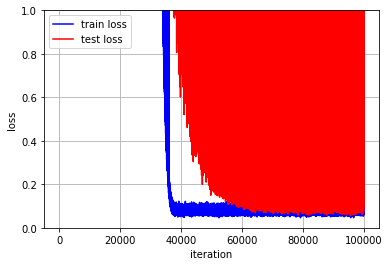

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.grid()
plt.plot(loss_vec,c='b',linestyle='solid',label='train loss')

plt.plot(test_loss_vec,c='r',label='test loss')

#plt.xlim(60000,60100)
plt.ylim(0,1)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.savefig(str(hidden_size)+'.png')
plt.legend()

In [10]:
# 重みの保存
saver = tf.train.Saver()
saver.save(sess, './model.ckpt')


'./model.ckpt'

In [11]:
'''
# ボール座標とスティックの傾きプロット
by_max=IN_train.max(axis=0)[1]
by_min=IN_train.min(axis=0)[1]

ball_y = np.array(range(int(by_min)-3,int(by_max)+3))
for i in range(len(ball_y)):
    
    ball = np.array([[6.0, ball_y[i]/10.0]])
    
    print(ball)
    joy = sess.run(final_output, feed_dict={INPUT: ball})
    plt.scatter(ball[0][1],ball[0][0], s=200, c='orange')
    
    plt.quiver(0,0,-joy[0][0],-joy[0][1],angles="xy",scale_units="xy",scale=1)
    #plt.quiver(0,0,-0.6,5,angles="xy",scale_units="xy",scale=1)
    print(joy)
    plt.savefig(str(hidden_size)+'_img'+'.png')
    '''

'\n# ボール座標とスティックの傾きプロット\nby_max=IN_train.max(axis=0)[1]\nby_min=IN_train.min(axis=0)[1]\n\nball_y = np.array(range(int(by_min)-3,int(by_max)+3))\nfor i in range(len(ball_y)):\n    \n    ball = np.array([[6.0, ball_y[i]/10.0]])\n    \n    print(ball)\n    joy = sess.run(final_output, feed_dict={INPUT: ball})\n    plt.scatter(ball[0][1],ball[0][0], s=200, c=\'orange\')\n    \n    plt.quiver(0,0,-joy[0][0],-joy[0][1],angles="xy",scale_units="xy",scale=1)\n    #plt.quiver(0,0,-0.6,5,angles="xy",scale_units="xy",scale=1)\n    print(joy)\n    plt.savefig(str(hidden_size)+\'_img\'+\'.png\')\n    '

In [12]:
# 重みのrestore
predicts_sess = tf.Session(config=config)
ckpt = tf.train.get_checkpoint_state('./')
if ckpt == None:
    print('!!!!!!!WEIGHTS NOT FOUND!!!!!!')

saver.restore(predicts_sess, './model.ckpt')

INFO:tensorflow:Restoring parameters from ./model.ckpt
